In [10]:
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

Cleaning up treatment train information
1. Filter for Activity Status = Active and Facility Status = Active
2. Remove PWS ID- Facility ID pairs with only 1 treatment step
3. Get frequency of Treatment Process-Treatment Objective pairs. Drop pairs with frequency less than 10
4. Map physical/chemical classification
5. Map chemical type
6. Map physical type (Not sure how to do this yet)


In [11]:
# df_latest has sdwis data for all 4 quarters and drops duplicates
sdwis = pd.read_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\df_latest.csv')
# sdwis = pd.read_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\SDWIS.csv')
# Read mapping file
treatment_classification = pd.read_excel(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\grouped_treatment_processes_2020_MH.xlsx')

C:\Users\mhardika\AppData\Local\Temp\1\ipykernel_16632\2158044353.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  sdwis = pd.read_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\df_latest.csv')


In [12]:
# Drop rows with duplicate PWS ID, Facility ID and treatment unit
sdwis_filtered = sdwis[['PWS ID','Facility Id','PWS Name', 'Population Served Count', 'Activity Status', 'Facility Activity', 'Primary Source', 'PWS Type','Treatment Process','Treatment Objective']].drop_duplicates(subset = ['PWS ID','Facility Id','Treatment Process'])
# Filter for Facility activity = Active
sdwis_filtered = sdwis_filtered[sdwis_filtered['Facility Activity']=='Active']
# Remove rows without an treatment process listed
sdwis_filtered = sdwis_filtered.dropna(subset=['Treatment Process'])
# Remove PWS ID and Facility with only 1 treatment process
sdwis_filtered = sdwis_filtered.groupby(['PWS ID','Facility Id']).filter(lambda x: len(x['Treatment Process'])>1).reset_index()

In [25]:
sdwis_filtered_two_step = sdwis_filtered.groupby(['PWS ID','Facility Id']).filter(lambda x: len(x['Treatment Process'])==2)

In [13]:
print('Before filtering SDWIS:', len(sdwis))
print('After filtering SDWIS:', len(sdwis_filtered) )

Before filtering SDWIS: 163436
After filtering SDWIS: 123872


In [35]:
unique_treatment = sdwis_filtered.groupby(['Treatment Process','Treatment Objective']).size().reset_index()
unique_treatment = unique_treatment.sort_values(0,ascending=False)
unique_treatment.rename(columns={0:'Frequency'},inplace=True)
# Drop pairs that have frequency < 10
# unique_treatment.to_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files_2024\sdwis_treatment_list.csv')
unique_treatment = unique_treatment[unique_treatment['Frequency']>10]

In [15]:
unique_treatment_process = pd.DataFrame(unique_treatment['Treatment Process'].unique()).reset_index(drop = True)
# unique_treatment_process.to_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files_2024\sdwis_treatment_process_list.csv')

In [33]:
unique_treatment_classified = unique_treatment.merge(treatment_classification, left_on='Treatment Process', right_on='treatment_process')
# unique_treatment_classified.to_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files_2024\sdwis_treatment_list_classified.csv')
# unique_treatment_classified

C:\Users\mhardika\AppData\Local\Temp\1\ipykernel_16632\3527590382.py:18: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  chemical_patch = mpatches.Patch(edgecolor='black', color = "cornflowerblue" , label = 'Chemical Processes')
C:\Users\mhardika\AppData\Local\Temp\1\ipykernel_16632\3527590382.py:19: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  physical_patch = mpatches.Patch(edgecolor='black', color = "darkorange" , label = 'Physical Processes')


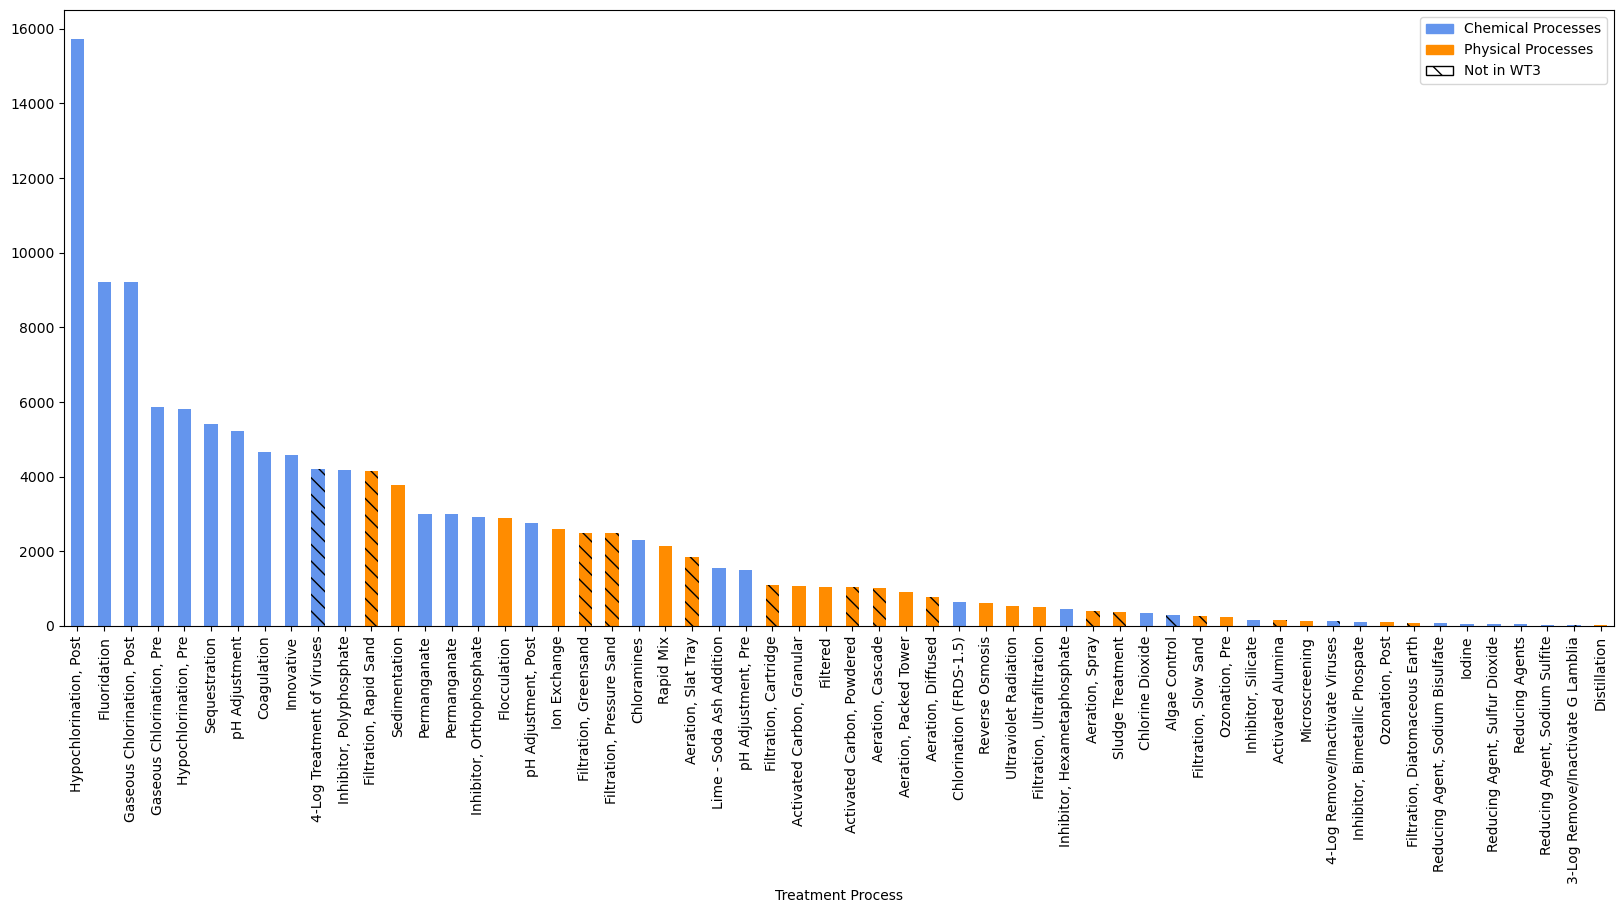

In [37]:
unique_treatment_frequency = unique_treatment.groupby(['Treatment Process']).sum().reset_index()
unique_treatment_frequency = unique_treatment_frequency.sort_values('Frequency',ascending=False)
# unique_treatment_frequency.to_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files_2024\sdwis_treatment_list_frequency.csv')

unique_treatment_frequency = unique_treatment_frequency.merge(treatment_classification, left_on='Treatment Process', right_on='treatment_process')


fig, ax = plt.subplots()
unique_treatment_frequency.plot.bar(ax = ax, x='Treatment Process', y = 'Frequency', figsize=(20,8))
bars = ax.patches
hatches = ["" if x == 'yes' else '\\\\' for x in unique_treatment_frequency['In WT3']]
colors = ["cornflowerblue" if x == 'chemical' else 'darkorange' for x in unique_treatment_frequency['physical_chemical']]

for bar,hatch,color in zip(bars,hatches,colors):
    bar.set_facecolor(color)
    bar.set_hatch(hatch)

chemical_patch = mpatches.Patch(edgecolor='black', color = "cornflowerblue" , label = 'Chemical Processes')
physical_patch = mpatches.Patch(edgecolor='black', color = "darkorange" , label = 'Physical Processes')
in_wt3 = mpatches.Patch(edgecolor='black', facecolor= 'white', hatch = "\\" , label = 'Not in WT3')

ax.legend(handles=[chemical_patch,physical_patch,in_wt3])
# ax.set_yscale('log')    

C:\Users\mhardika\AppData\Local\Temp\1\ipykernel_16632\2142264230.py:16: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  chemical_patch = mpatches.Patch(edgecolor='black', color = "cornflowerblue" , label = 'Chemical Processes')
C:\Users\mhardika\AppData\Local\Temp\1\ipykernel_16632\2142264230.py:17: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  physical_patch = mpatches.Patch(edgecolor='black', color = "darkorange" , label = 'Physical Processes')


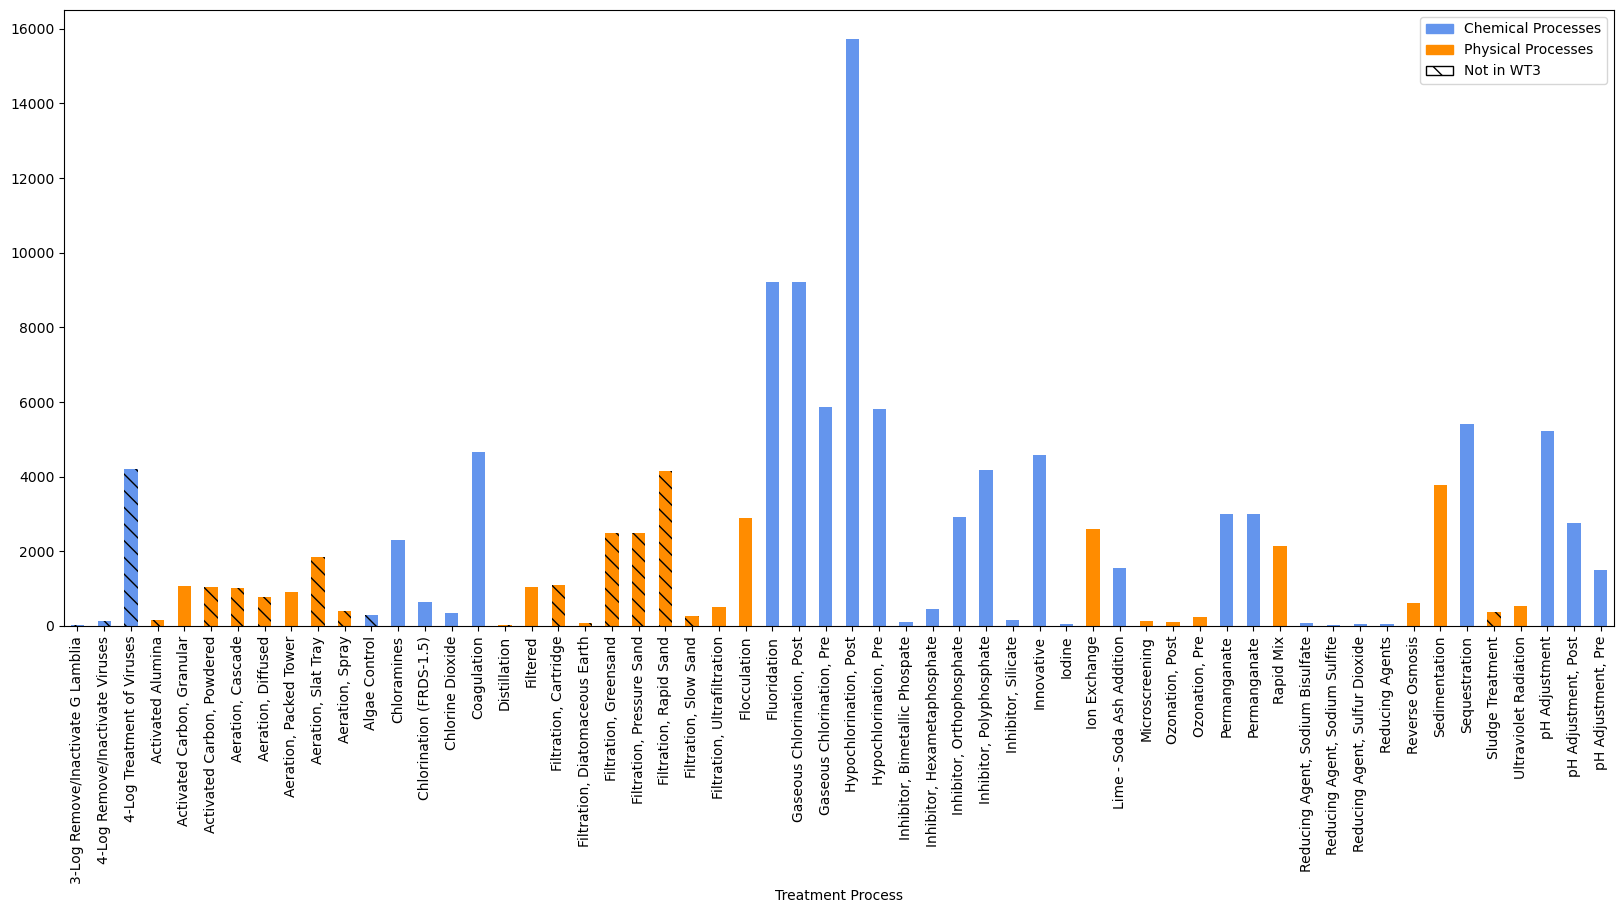

In [38]:
unique_treatment_frequency = unique_treatment.groupby(['Treatment Process']).sum().reset_index()
# unique_treatment_frequency = unique_treatment_frequency.sort_values('Frequency',ascending=False)
unique_treatment_frequency = unique_treatment_frequency.merge(treatment_classification, left_on='Treatment Process', right_on='treatment_process')


fig, ax = plt.subplots()
unique_treatment_frequency.plot.bar(ax = ax, x='Treatment Process', y = 'Frequency', figsize=(20,8))
bars = ax.patches
hatches = ["" if x == 'yes' else '\\\\' for x in unique_treatment_frequency['In WT3']]
colors = ["cornflowerblue" if x == 'chemical' else 'darkorange' for x in unique_treatment_frequency['physical_chemical']]

for bar,hatch,color in zip(bars,hatches,colors):
    bar.set_facecolor(color)
    bar.set_hatch(hatch)

chemical_patch = mpatches.Patch(edgecolor='black', color = "cornflowerblue" , label = 'Chemical Processes')
physical_patch = mpatches.Patch(edgecolor='black', color = "darkorange" , label = 'Physical Processes')
in_wt3 = mpatches.Patch(edgecolor='black', facecolor= 'white', hatch = "\\" , label = 'Not in WT3')

ax.legend(handles=[chemical_patch,physical_patch,in_wt3])
# ax.set_yscale('log')    

In [ ]:
# Which process occur together most frequently? 